In [20]:
import os
import subprocess
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Define paths for dataset download and extraction
zip_path = os.path.expanduser('~/Downloads/videogamesales.zip')
extract_path = os.path.expanduser('~/Downloads/videogamesales')

# Download Dataset using Kaggle API
if not os.path.exists(zip_path):
    print("Downloading dataset from Kaggle...")
    subprocess.run([
        "kaggle", "datasets", "download", "-d", "gregorut/videogamesales", "-p", os.path.expanduser('~/Downloads'), "--unzip"
    ])
    print("Download complete.")

# Extract Dataset if not already extracted
if os.path.exists(zip_path) and not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")

# Verify extracted files
if os.path.exists(extract_path):
    print("Extracted files:", os.listdir(extract_path))

# Load dataset
csv_file = os.path.join(extract_path, 'vgsales.csv')
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print("Dataset loaded successfully.")
else:
    print("Dataset file not found.")
    exit()

Extracted files: ['vgsales.csv', 'vgsales_cleaned.csv']
Dataset loaded successfully.


In [24]:
# Handle missing values
df['Year'] = df['Year'].fillna(df['Year'].mean())
df['Publisher'] = df['Publisher'].fillna(df['Publisher'].mode()[0])

# Apply Label Encoding to categorical columns
label_enc_cols = ["Platform", "Genre"]
label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Defining Features and Target
X = df[['Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
y = df['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Model Training and Evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto'),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42),
    'Extra Tree': ExtraTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=4, random_state=42),
    'Bagging Regressor': BaggingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=4, min_samples_split=5, min_samples_leaf=3),
        n_estimators=700,
        learning_rate=0.5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42),
    'Support Vector Machine (Linear)': SVR(kernel='linear', C=1.5, epsilon=0.05),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42)
}

results = {}
train_times = {}
mse_scores = {}
mae_scores = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    results[name] = r2_score(y_test, y_pred)
    mse_scores[name] = mean_squared_error(y_test, y_pred)
    mae_scores[name] = mean_absolute_error(y_test, y_pred)
    train_times[name] = train_time

In [34]:
# Convert results to DataFrame
model_summary = pd.DataFrame({
    'Model': results.keys(),
    'R² Score': results.values(),
    'MSE': mse_scores.values(),
    'MAE': mae_scores.values(),
    'Training Time': train_times.values()
})
model_summary.sort_values(by='R² Score', ascending=False, inplace=True)


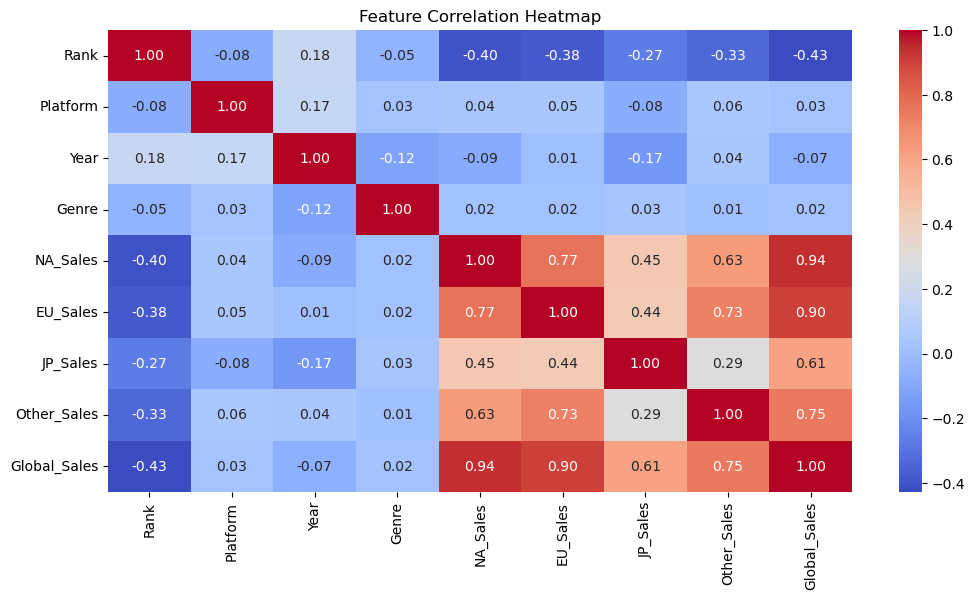

In [36]:
# Heatmap for Feature Correlation
plt.figure(figsize=(12, 6))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


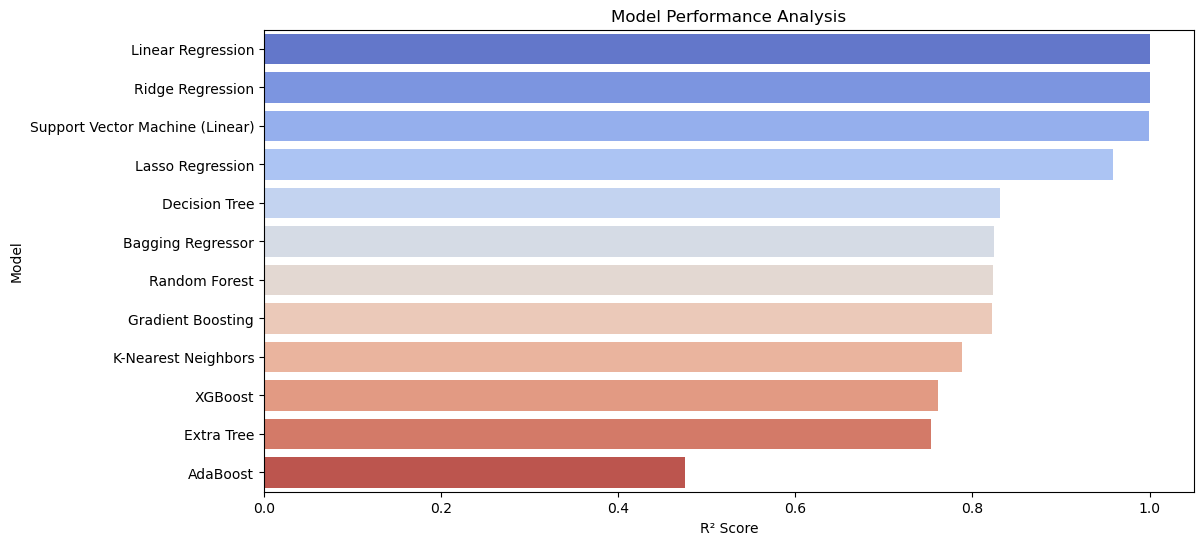

In [40]:
# Additional Visualizations
plt.figure(figsize=(12, 6))
sns.barplot(y='Model', x='R² Score', hue='Model', data=model_summary, palette='coolwarm', legend=False)
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.title("Model Performance Analysis")
plt.show()

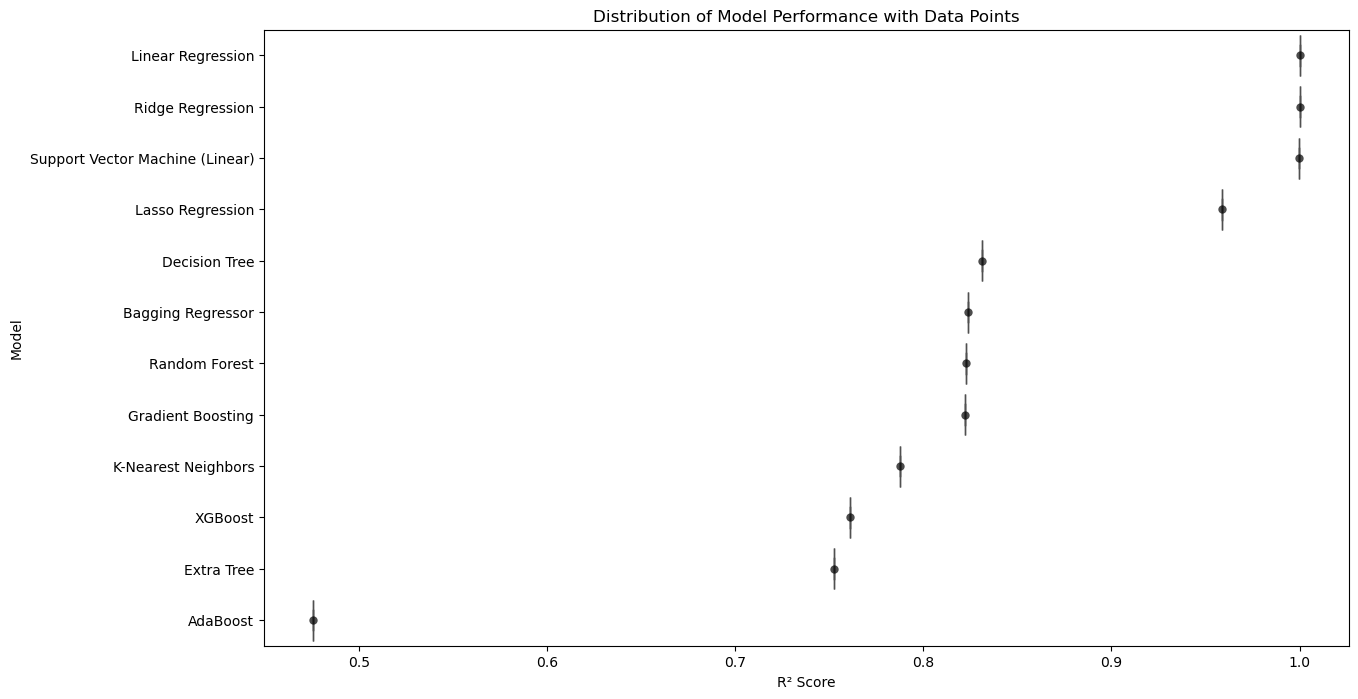

In [56]:
# Improved Boxplot for Model Performance
plt.figure(figsize=(14, 8))
sns.boxplot(x='R² Score', y='Model', hue='Model', data=model_summary, palette='coolwarm', legend=False)
sns.stripplot(x='R² Score', y='Model', data=model_summary, color='black', size=6, jitter=True, alpha=0.7)
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.title("Distribution of Model Performance with Data Points")
plt.show()

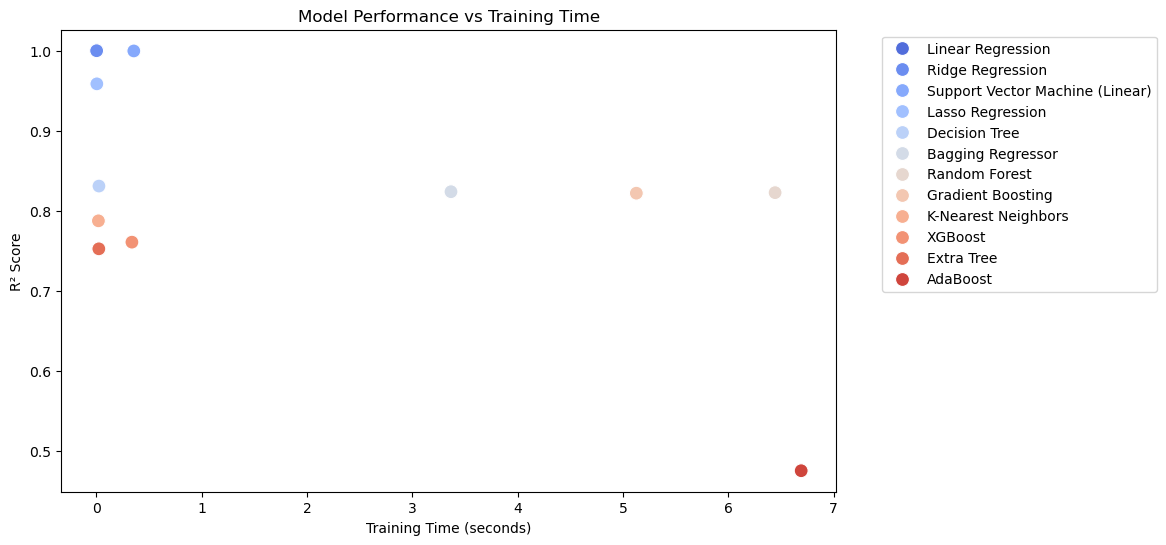

In [44]:
# Scatter Plot for R² Score vs Training Time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Training Time', y='R² Score', data=model_summary, hue='Model', palette='coolwarm', s=100)
plt.xlabel("Training Time (seconds)")
plt.ylabel("R² Score")
plt.title("Model Performance vs Training Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()